In [1]:
from oggm import cfg

cfg.initialize()

2023-10-10 10:47:57: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-10-10 10:47:57: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-10-10 10:47:57: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-10-10 10:47:57: oggm.utils: Checking the download verification file checksum...


In [2]:
cfg.CONFIG_FILE

'/home/ruitang/.oggm_config'

In [1]:
# 1. Initial settings
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np
import time,os
import xarray as xr
import pickle
from scipy import stats
plt.rcParams.update({'font.size': 16})
################################
# import oggm and Get the default params
from oggm import cfg, utils, workflow, tasks, graphics
import oggm.cfg as cfg
cfg.initialize(logging_level='WORKFLOW')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False
from oggm.core.massbalance import ScalarMassBalance
from oggm.core import massbalance
from oggm.core.massbalance import mb_calibration_from_scalar_mb, mb_calibration_from_geodetic_mb, mb_calibration_from_wgms_mb
from oggm.tests.funcs import bu_tidewater_bed
from oggm.core.massbalance import MultipleFlowlineMassBalance, MonthlyTIModel
from oggm.core.flowline import FluxBasedModel,fa_sermeq_speed_law, k_calving_law
################################
# import the Graphics
import Graphics_RT
from Graphics_RT import plot_modeloutput_section_New
################################
#setting the workplace
rgi_id = 'RGI60-01.10689'
Figpath='/home/ruitang/OGGM-Ruitang/Results/Test_T1/'+rgi_id
Figpath_Folder_all=utils.mkdir(Figpath,reset=True)

# figure
Figpath_Folder_tif_path=Figpath+'/Tif/'
Figpath_Folder_png_path=Figpath+'/Png/'
Figpath_Folder_tif=utils.mkdir(Figpath_Folder_tif_path,reset=True)
Figpath_Folder_png=utils.mkdir(Figpath_Folder_png_path,reset=True)
# data
Figpath_Folder_data_path=Figpath+'/Data/'
Figpath_Folder_data=utils.mkdir(Figpath_Folder_data_path,reset=True)
file_txt_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.txt'
with open(file_txt_path_name,"w") as file:
    file.write("************* Here is the model results for glacier {}************* \n".format(rgi_id))
file_data_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.pickle'

/home/ruitang/OGGM-Ruitang/oggm_Ruitang/oggm/cfg.py:373: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2023-10-18 13:53:10: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-10-18 13:53:10: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-10-18 13:53:10: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-10-18 13:53:12: oggm.cfg: PARAMS['cfl_n

In [3]:
# download the glacier inventory dataset
 # Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] =Figpath
cfg.PARAMS['store_model_geometry'] = True
# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True
# Download from the "OGGM shop"
# Go - get the pre-processed glacier directories
# You have to explicitly indicate the url from where you want to start from
# base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/'
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
gdir_woc = workflow.init_glacier_directories([rgi_id], from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)[0]


2023-10-18 13:55:12: oggm.cfg: Multiprocessing switched ON after user settings.
2023-10-18 13:55:12: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-10-18 13:55:12: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [4]:
gdir_woc

<oggm.GlacierDirectory>
  RGI id: RGI60-01.10689
  Region: 01: Alaska
  Subregion: 01-04: W Chugach Mtns (Talkeetna)      
  Name: Columbia Glacier
  Glacier type: Glacier
  Terminus type: Marine-terminating
  Status: Glacier or ice cap
  Area: 773.873 km2
  Lon, Lat: (-146.888, 61.299)
  Grid (nx, ny): (223, 233)
  Grid (dx, dy): (200.0, -200.0)

In [7]:
gdir_woc.rgi_date

2009

In [10]:
os.listdir(gdir_woc.dir)

['diagnostics.json',
 'dem.tif',
 'inversion_input.pkl',
 'outlines.tar.gz',
 'model_flowlines.pkl',
 'gridded_data.nc',
 'climate_historical.nc',
 'mb_calib.json',
 'centerlines.pkl',
 'glacier_grid.json',
 'inversion_output.pkl',
 'dem_source.txt',
 'geometries.pkl',
 'log.txt',
 'flowline_catchments.tar.gz',
 'intersects.tar.gz',
 'inversion_flowlines.pkl',
 'catchments_intersects.tar.gz']

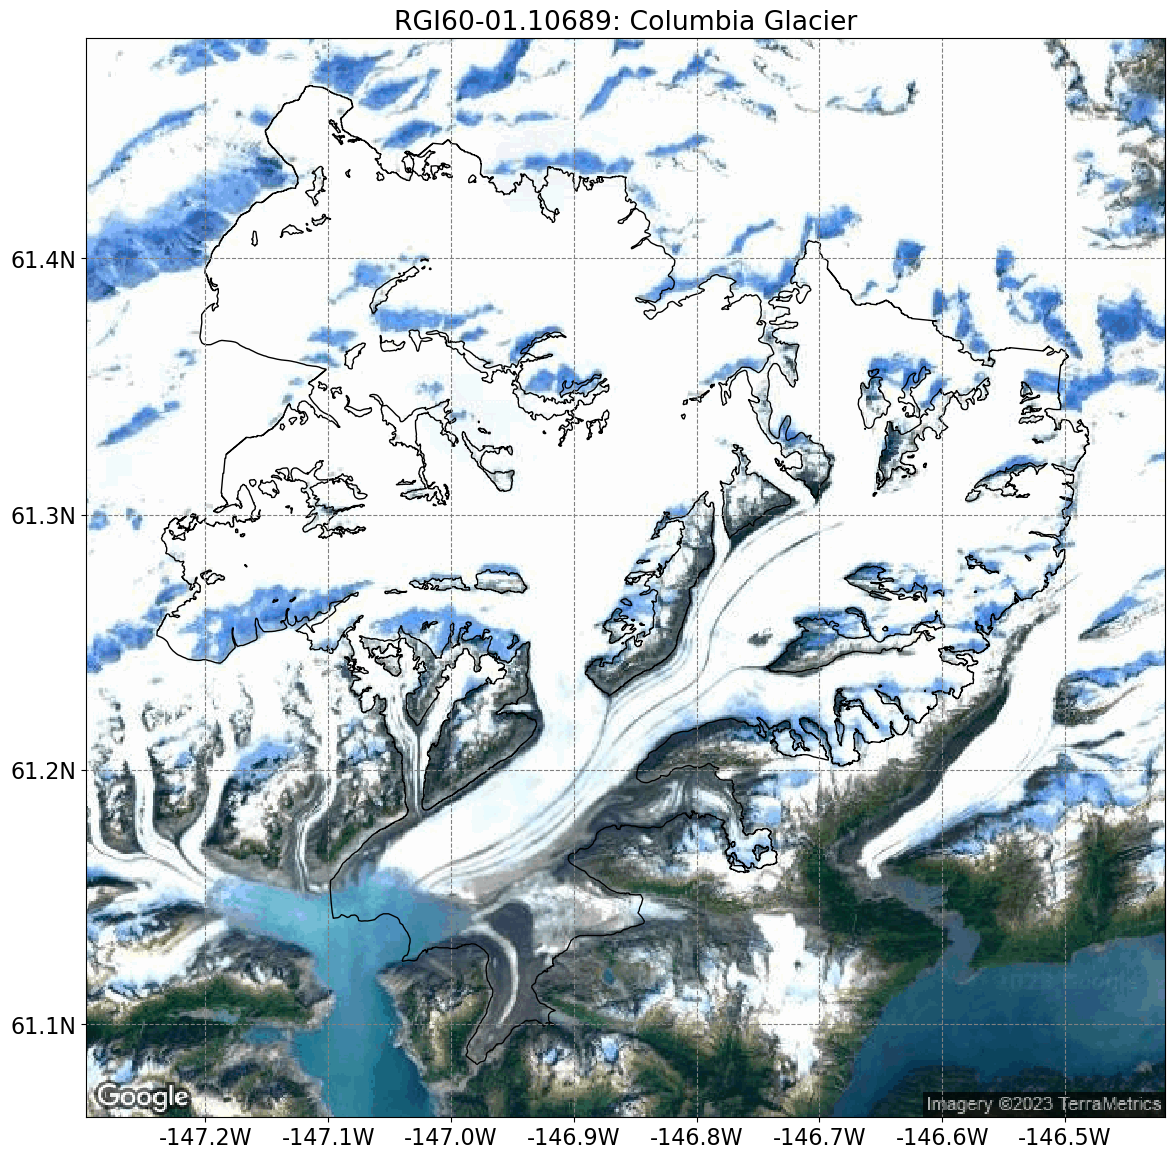

In [17]:
#tasks.init_present_time_glacier(gdir_woc)
graphics.plot_googlemap(gdir_woc, figsize=(12,12));

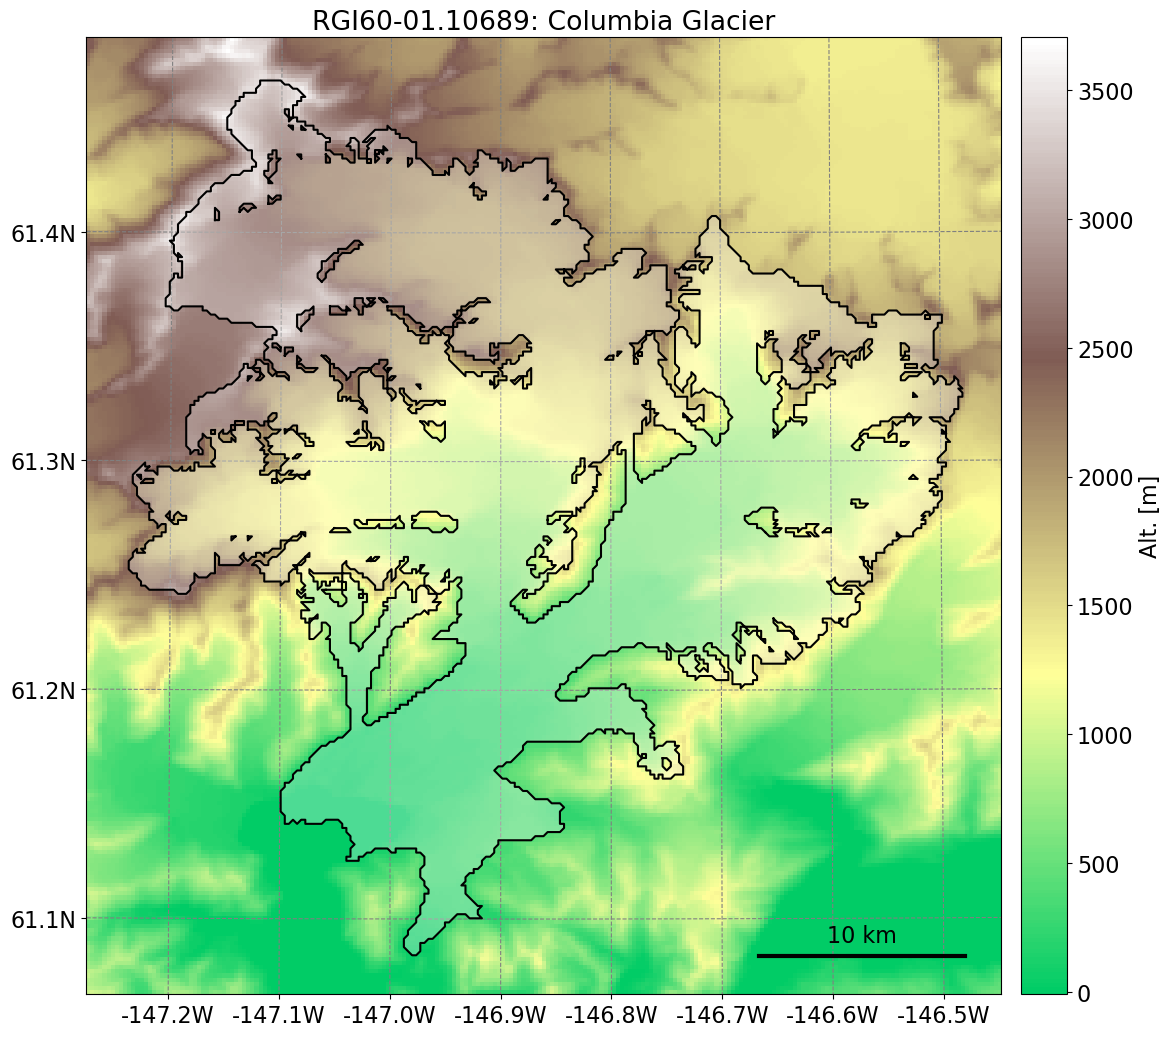

In [16]:
graphics.plot_domain(gdir_woc, figsize=(12, 12))

In [18]:
inversion_output = gdir_woc.read_pickle('inversion_output')  

In [19]:
inversion_output

[{'dx': 400.0,
  'flux_a0': array([0.00012363, 0.00023866, 0.00032866, 0.00040199, 0.00049925,
         0.00063222, 0.00076132, 0.00086671, 0.00096625, 0.00107681,
         0.00118482]),
  'width': array([2932.22138452, 3026.52311844, 3356.22272718, 3765.51094492,
         3842.70205349, 3617.48315729, 3451.10181387, 3407.09985835,
         3382.39755168, 3317.74153826, 3265.914157  ]),
  'slope_angle': array([0.14997225, 0.15112136, 0.13038879, 0.0953449 , 0.07578216,
         0.06806205, 0.06384048, 0.05279786, 0.03627843, 0.02167031,
         0.015441  ]),
  'is_rectangular': array([False, False, False, False, False, False, False, False, False,
         False, False]),
  'is_trapezoid': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]),
  'flux': array([0.24167473, 0.48153844, 0.73537382, 1.00914157, 1.27896684,
         1.52469967, 1.75160635, 1.96863395, 2.17881729, 2.3817213 ,
         2.57967101]),
  'is_last': False,
  'hgt': array([2

In [20]:
type(inversion_output)

list

In [21]:
len(inversion_output)

21

In [23]:
type(inversion_output[-1])

dict

In [25]:
list(inversion_output[-1].keys())

['dx',
 'flux_a0',
 'width',
 'slope_angle',
 'is_rectangular',
 'is_trapezoid',
 'flux',
 'is_last',
 'hgt',
 'invert_with_trapezoid',
 'thick',
 'volume',
 'volume_bsl']

In [29]:
inversion_output[-1]['dx']

400.0

In [31]:
len(inversion_output[-1]['flux_a0'])

136

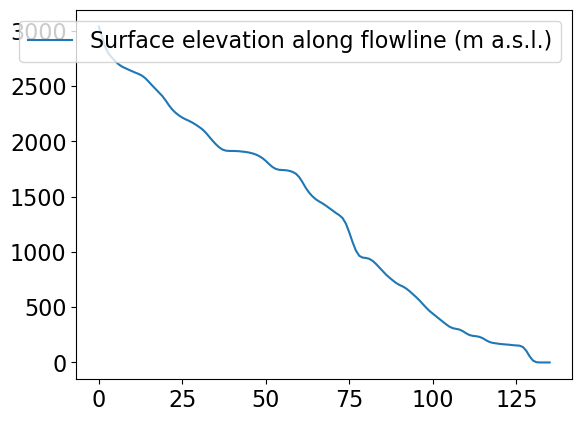

In [28]:
surface_hgt=inversion_output[-1]['hgt']
plt.plot(surface_hgt, label='Surface elevation along flowline (m a.s.l.)'); plt.legend();

In [27]:
inversion_output[-1]['slope_angle']

array([ 2.38433255e-01,  2.38212732e-01,  1.90123790e-01,  1.17155241e-01,
        8.52324676e-02,  7.36180938e-02,  5.95991595e-02,  4.34973776e-02,
        3.52591918e-02,  3.40098121e-02,  3.29081301e-02,  3.08504758e-02,
        3.45233249e-02,  4.94519884e-02,  6.89028768e-02,  8.00365971e-02,
        7.99379053e-02,  7.63845656e-02,  7.86720499e-02,  9.08876180e-02,
        1.05312307e-01,  1.04064861e-01,  8.51977655e-02,  6.66818388e-02,
        5.47385398e-02,  4.39889234e-02,  3.63495483e-02,  3.64968315e-02,
        4.24158907e-02,  4.81659128e-02,  5.31099886e-02,  6.46715590e-02,
        8.10362777e-02,  8.88587974e-02,  8.58111618e-02,  7.70419451e-02,
        6.12564152e-02,  3.84026381e-02,  1.64299781e-02,  3.79230235e-03,
        9.59169562e-04,  3.10447437e-03,  6.10382574e-03,  8.50479861e-03,
        1.12692970e-02,  1.56048115e-02,  2.18225706e-02,  3.01501378e-02,
        4.10748840e-02,  5.49386965e-02,  6.75946894e-02,  6.88826311e-02,
        5.43285949e-02,  

# Velocity inversion

In [32]:
from oggm import tasks

# run the compute_inversion_velocities task on all gdirs
workflow.execute_entity_task(tasks.compute_inversion_velocities, gdir_woc);

2023-10-18 15:15:28: oggm.workflow: Execute entity tasks [compute_inversion_velocities] on 1 glaciers


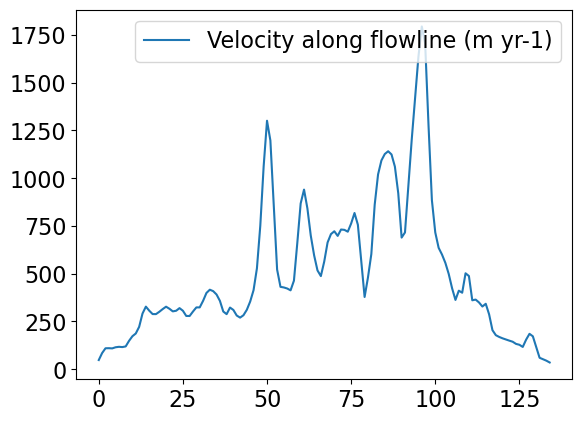

In [59]:
inversion_output = gdir_woc.read_pickle('inversion_output')  # The task above wrote the data to a pickle file - but we write to plenty of other files!

# Take the first flowline
fl = inversion_output[-1]
# the last grid points often have irrealistic velocities
# because of the equilibrium assumption
vel = fl['u_surface'][:-1]  
plt.plot(vel, label='Velocity along flowline (m yr-1)'); plt.legend();

In [61]:
type(fl)

dict

In [62]:
list(fl.keys())

['dx',
 'flux_a0',
 'width',
 'slope_angle',
 'is_rectangular',
 'is_trapezoid',
 'flux',
 'is_last',
 'hgt',
 'invert_with_trapezoid',
 'thick',
 'volume',
 'volume_bsl',
 'u_integrated',
 'u_surface',
 'u_basal',
 'u_deformation']

In [37]:
fls = gdir_woc.read_pickle('model_flowlines')

In [38]:
fls

In [39]:
len(fls)

21

In [40]:
fls[-1]

In [65]:
dir(fls[-1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_attrs_to_dataset',
 '_compute_point_lls',
 '_do_trapeze',
 '_lambdas',
 '_point_lats',
 '_point_lons',
 '_prec',
 '_ptrap',
 '_sqrt_bed',
 '_surface_h',
 '_thick',
 '_vol_below_level',
 '_w0_m',
 '_widths',
 'apparent_mb',
 'area_km2',
 'area_m2',
 'bed_h',
 'bed_shape',
 'bin_area_m2',
 'calving_bucket_m3',
 'dis_on_line',
 'dx',
 'dx_meter',
 'flows_to',
 'flows_to_indice',
 'flows_to_point',
 'flux',
 'flux_needs_correction',
 'flux_out',
 'geometrical_widths',
 'has_ice',
 'head',
 'inflow_indices',
 'inflow_points',
 'inflows',
 'is_rectangular',
 'is_trapezoid',
 'length_m',


In [47]:
tasks.init_present_time_glacier(gdir_woc,filesuffix='_Velocity')

In [48]:
os.listdir(gdir_woc.dir)

['diagnostics.json',
 'dem.tif',
 'inversion_input.pkl',
 'outlines.tar.gz',
 'model_flowlines.pkl',
 'gridded_data.nc',
 'climate_historical.nc',
 'mb_calib.json',
 'model_flowlinesVelocity.pkl',
 'centerlines.pkl',
 'glacier_grid.json',
 'inversion_output.pkl',
 'dem_source.txt',
 'geometries.pkl',
 'log.txt',
 'flowline_catchments.tar.gz',
 'intersects.tar.gz',
 'inversion_flowlines.pkl',
 'catchments_intersects.tar.gz',
 'model_flowlines_Velocity.pkl']

In [52]:
cfg.add_to_basenames('model_flowlines_Velocity','model_flowlines_Velocity.pkl')

In [57]:
fls_vl = gdir_woc.read_pickle('model_flowlines_Velocity')
len(dir(fls_vl[-1]))

98

# Calving inversion

In [ ]:
1. 